# Machine learning algorithms on wholesale costumers data (ongoing)
## Predicting sales channel with SVM, Random Forest and XGBoost algorithms.

The problem is the following: given the annual spending on 6 different type of products of 440 wholesale customers, is it possible to predict the customers channel? In another notebook on this repo, *Principal Component Analyis on wholesale customers data*, I segmented these same costumers into three different groups and I found some differences between customer segment and channel, which is a positive indication that there is a pattern to be predicted.

The dataset I used can be found [here](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers).
It is originated from a larger database referred on: 

*Abreu, N. (2011). Analise do perfil do cliente Recheio e desenvolvimento de um sistema promocional. Mestrado em Marketing, ISCTE-IUL, Lisbon*

Dataset variable description:

- FRESH: annual spending (m.u.) on fresh products (Continuous)
- MILK: annual spending (m.u.) on milk products (Continuous)
- GROCERY: annual spending (m.u.) on grocery products (Continuous)
- FROZEN: annual spending (m.u.) on frozen products (Continuous) 
- DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous) 
- DELICATESSEN: annual spending (m.u.) on and delicatessen products (Continuous) 
- **CHANNEL: customers Channel - Horeca (Hotel/Restaurant/Cafe) or Retail channel (Nominal)** 
- REGION: customers Region - Lisbon, Oporto or Other (Nominal) 

In [5]:
import pandas as pd

# Load the dataset
dataset = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
df = pd.read_csv(dataset)

# List only continous variables (products), I'll deal with nominal vars later
products = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

In [101]:
df.shape

(440, 8)

In [107]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [240]:
df[products].describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


## t-SNE

In [368]:
from sklearn.manifold import TSNE

dtsne = TSNE(learning_rate=300).fit_transform(df[products])

In [416]:
import seaborn as sns
%matplotlib inline

tsnedf = pd.DataFrame({'x':dtsne[:,0],
                       'y':dtsne[:,1], 
                       'Channel':df['Channel'],
                       'Region':df['Region']})

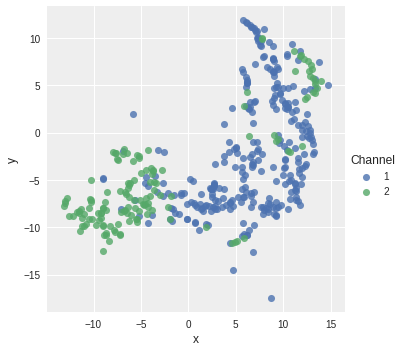

In [417]:
sns.lmplot('x', 'y', 
           data=tsnedf, 
           fit_reg=False,
           hue='Channel',  
           scatter_kws={"marker": "D", 
                        "s": 50})

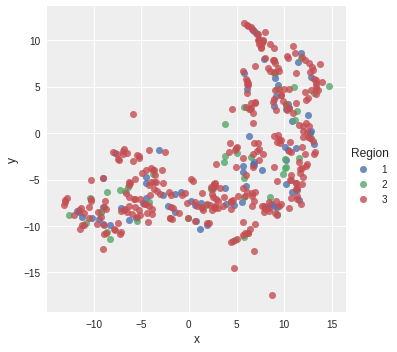

In [418]:
sns.lmplot('x', 'y', 
           data=tsnedf, 
           fit_reg=False,
           hue='Region',  
           scatter_kws={"marker": "D", 
                        "s": 50})

Judging by the tSNE plot, an unsupervised clustering method, the channel has two obvious clusters. The Region, on the other side, is scattered around the plot without any obvious clustering. The fact that the Channel is clustered is a good indication for the application of machine learning algorithms. I'll start with a simple algorithm, a Linear SVM.

## Support Vector Machine

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# do a 66-33 train/test data split. 

X_train, X_test, y_train, y_test = train_test_split(df[products], 
                                                    df['Channel'], 
                                                    test_size=0.33, 
                                                    random_state=42)

# try different params for GridSearch.

tuned_parameters = [{'kernel': ['linear'], 'C': [75, 100, 125]}]

# build a classifier with gridsearch
clf = GridSearchCV(SVC(C=1), 
                   tuned_parameters, 
                   cv=5,
                   scoring="accuracy",
                   n_jobs=4)

# Fit the classifier
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid=[{'kernel': ['linear'], 'C': [75, 100, 125]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [102]:
clf.best_estimator_

SVC(C=75, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [144]:
accuracy = accuracy_score(y_test, clf.predict(X_test))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Error: %.2f%%" % (100-accuracy * 100.0))

Accuracy: 90.41%
Error: 9.59%


The linear SVM got around 90% of accuracy in a cross-validated gridsearch, with c=75 being the best predictor. 90% for the first attempt is good, but I'll try another methods to raise it a little bit (it still mislabels 1 customers channel out of 10).

## Random Forests

In [251]:
from sklearn.ensemble import RandomForestClassifier

# build the classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [252]:
# print accuracy and error
accuracy = accuracy_score(y_test, clf.predict(X_test))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Error: %.2f%%" % (100-accuracy * 100.0))

Accuracy: 91.78%
Error: 8.22%


Close to 92% accuracy without any parameter tuning at all is good. I'll do a randomized parameter search next.

In [250]:
# Utility function to report best scores (from sklearn.org)

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [190]:
from sklearn.model_selection import RandomizedSearchCV
import time

# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "n_estimators": np.random.randint(10, 25, 100),
              "min_samples_split": np.random.randint(2, 35, 100),
              "min_samples_leaf": np.random.randint(1, 35, 100),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 1000
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, random_state=42,
                                   n_jobs=-1)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 35.85 seconds for 1000 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.932 (std: 0.026)
Parameters: {'n_estimators': 21, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': True}

Model with rank: 2
Mean validation score: 0.929 (std: 0.030)
Parameters: {'n_estimators': 10, 'min_samples_split': 15, 'min_samples_leaf': 19, 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': True}

Model with rank: 2
Mean validation score: 0.929 (std: 0.022)
Parameters: {'n_estimators': 18, 'min_samples_split': 9, 'min_samples_leaf': 14, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}

Model with rank: 2
Mean validation score: 0.929 (std: 0.016)
Parameters: {'n_estimators': 15, 'min_samples_split': 15, 'min_samples_leaf': 17, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': True}

Model with rank: 2
Mean validation score: 0.929 (std: 0.022)
Parameters: {'n_estimators': 20, 'min_samples_split

In [191]:
random_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=6,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            n_estimators=21, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [193]:
accuracy = accuracy_score(y_test, random_search.predict(X_test))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Error: %.2f%%" % (100-accuracy * 100.0))

Accuracy: 93.15%
Error: 6.85%


The randomized search got better parameters than the default ones. I've upped the accuracy from 91.78% to 93.15% with Random Forests. 

## XGBoost

Next I'll try to predict the Channel using XGBoost, a gradient boosting trees model which is very popular amongst Kaggle competitors, who boast its high speed and good accuracies without overfitting.

In [436]:
import xgboost

#build a classifier
xgb = xgboost.XGBClassifier(learning_rate =0.2, gamma=0,
                            objective='binary:logistic', seed=42)

#fit the classifier
xgb.fit(X_train, y_train)

accuracy = accuracy_score(y_test, xgb.predict(X_test))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.84%


~94% accuracy just out-of-the-box is way too impressive. It was also a very quick fit, opposed to the linear SVM which took around 15 minutes. I'll do a 5-fold cross validation to check how well the model performs in practice. This approach will create 5 different subsets of the dataset and average the scores to get a more robust estimate of model performance.

In [434]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Try a 5-fold CV
kfold = KFold(n_splits=5, random_state=42)
accuracy = cross_val_score(xgb, X_train, y_train, cv=kfold)

print("Accuracy 5-fold CV: %.2f%% (±%.2f%%)" % (accuracy.mean()*100, accuracy.std()*100))
print("Max accuracy 5-fold CV: %.2f%%" % (accuracy.max()*100))
print("Min accuracy 5-fold CV : %.2f%%" % (accuracy.min()*100))


Accuracy 5-fold CV: 91.85% (±3.27%)
Max accuracy 5-fold CV: 94.92%
Min accuracy 5-fold CV : 86.44%


The model performs well enough, although it varied from 95% accuracy to 85% in the 5-fold cv. 

One advantage about xgboost (and other boosted trees methods) is that it returns features importance.

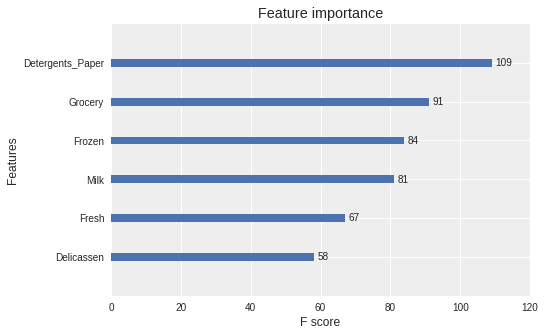

In [435]:
fig, ax = plt.subplots(figsize=(7.5, 5))
xgboost.plot_importance(xgb, ax=ax)

The more a feature is used to make key decisions within decision trees, the higher its relative importance is. In this case, the Detergents/Paper feature had the highest importance in predicting the channel while Delicatessen had the lowest.  

I'll plot the first decision tree, which makes the feature importance evident.

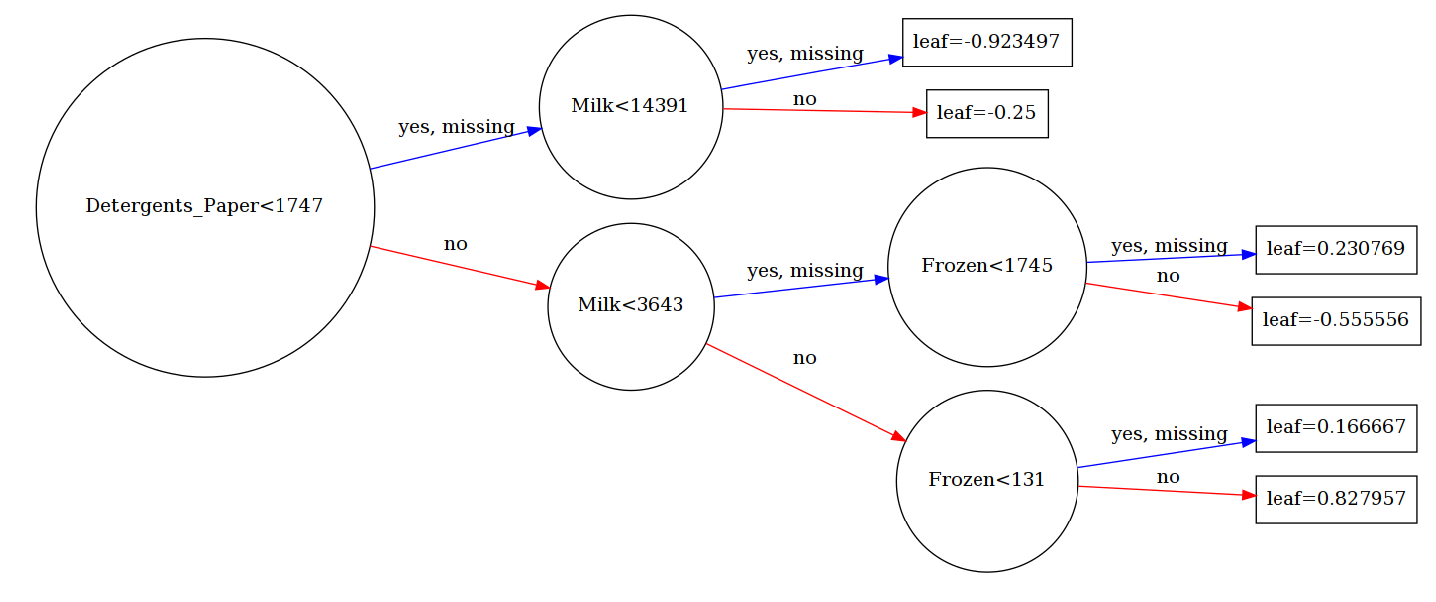

In [432]:
fig, ax = plt.subplots(figsize=(25, 25))

xgboost.plot_tree(xgb, rankdir='LR', num_trees= 0, ax=ax)

In [130]:
## This chunk is only relevant for Jupyter Notebook aesthetics.
from pylab import rcParams
import json
s = json.load( open("/home/hypathia/bmh_matplotlibrc.json") ) 
rcParams.update(s)

from IPython.core.display import HTML
def css_styling():
    styles = open("/home/hypathia/custom.css", "r").read() 
    return HTML(styles)
css_styling()